In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd
df_all = pd.read_csv("data/all_results_v2.csv")
df_thresholds = pd.read_csv("data/thresholded_results.csv")

In [3]:
df_joined = pd.merge(
    df_thresholds,                      # threshold-level
    df_all.drop_duplicates("join_key"),  # experiment-level
    on="join_key",
    how="left",
    suffixes=("", "_exp")        # avoid column name collisions
)

In [4]:
print(df_all.columns)
print(df_thresholds.columns)

Index(['join_key', 'experiment', 'experiment_date', 'model.loss',
       'model.model_architecture', 'model.pos_weight', 'model.alpha',
       'model.lr', 'dataloader.batch_size', 'training.max_epochs',
       'metrics.FPR_no_plume', 'metrics.accuracy', 'metrics.accuracy_easy',
       'metrics.accuracy_hard', 'metrics.balanced_accuracy',
       'metrics.balanced_accuracy_easy', 'metrics.balanced_accuracy_hard',
       'metrics.cohen_kappa', 'metrics.cohen_kappa_easy',
       'metrics.cohen_kappa_hard', 'metrics.f1score', 'metrics.f1score_easy',
       'metrics.f1score_hard', 'metrics.frac_total_easy',
       'metrics.frac_total_hard', 'metrics.iou', 'metrics.iou_easy',
       'metrics.iou_hard', 'metrics.precision', 'metrics.precision_easy',
       'metrics.precision_hard', 'metrics.recall', 'metrics.recall_easy',
       'metrics.recall_hard'],
      dtype='object')
Index(['join_key', 'experiment', 'experiment_date', 'model.loss',
       'model.model_architecture', 'model.pos_weight', 

In [5]:
architecture_mapping = {
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "fcn_resnet50": "FCN (ResNet-50)",
    "segformer": "SegFormer (B0)",
    "unet_mini": "U-Net (Mini)"
}


# --- Load ---
df = pd.read_csv("all_results_10-20-2024.csv")
df["model.model_architecture_display"] = df["model.model_architecture"].map(architecture_mapping)


/tmp/ipykernel_217327/3281261684.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))
/tmp/ipykernel_217327/3281261684.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))
/tmp/ipykernel_217327/3281261684.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))
/tmp/ipykernel_217327/3281261684.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))
/tmp/ipykernel_217327/3281261684

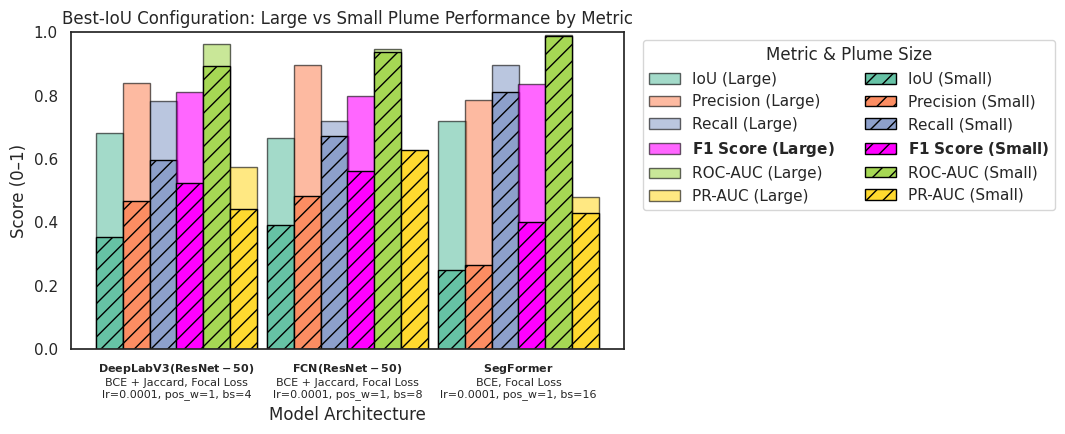

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1) Load base + thresholds
# ----------------------------
# Your tables (adjust paths if needed)
df_all = pd.read_csv("data/all_results_v2.csv")          # experiment-level (aka df_all)
df_thresholds = pd.read_csv("data/thresholded_results.csv")  # threshold-level

# Join (threshold rows + experiment metadata)
df_joined = pd.merge(
    df_thresholds,
    df_all.drop_duplicates("join_key"),
    on="join_key",
    how="left",
    suffixes=("", "_exp")
)

# ----------------------------
# 2) Build ROC-AUC & PR-AUC
# ----------------------------
import numpy as np

def compute_roc_pr_areas(group: pd.DataFrame) -> pd.Series:
    g = group.copy()
    g = g.replace([np.inf, -np.inf], np.nan).dropna(subset=["TPR", "FPR", "precision", "recall"])

    # ---- ROC-AUC via trapezoid over FPR (x) vs TPR (y)
    roc = g[["FPR", "TPR"]].dropna().sort_values("FPR")
    if roc.empty or roc.iloc[0]["FPR"] > 0:
        roc = pd.concat([pd.DataFrame({"FPR":[0.0], "TPR":[0.0]}), roc], ignore_index=True)
    if roc.iloc[-1]["FPR"] < 1:
        roc = pd.concat([roc, pd.DataFrame({"FPR":[1.0], "TPR":[1.0]})], ignore_index=True)
    roc = roc.groupby("FPR", as_index=False)["TPR"].max().sort_values("FPR")
    roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))

    # ---- PR-AUC (AP-style with precision envelope)
    pr = g[["recall", "precision"]].dropna().sort_values("recall")
    if pr.empty:
        pr_auc = np.nan
    else:
        pr["recall"] = pr["recall"].clip(0, 1)
        pr["precision"] = pr["precision"].clip(0, 1)
        prec_env = np.maximum.accumulate(pr["precision"].values[::-1])[::-1]
        if pr.iloc[0]["recall"] > 0:
            pr = pd.concat([pd.DataFrame({"recall":[0.0], "precision":[prec_env[0]]}), pr], ignore_index=True)
            prec_env = np.maximum.accumulate(pr["precision"].values[::-1])[::-1]
        r = pr["recall"].values
        pr_auc = float(np.sum((r[1:] - r[:-1]) * prec_env[1:]))

    # Baseline for AUPRC (prevalence)
    if "prevalence" in group.columns and group["prevalence"].notna().any():
        pr_baseline = float(group["prevalence"].dropna().iloc[0])
    elif {"TP","FP","TN","FN"}.issubset(group.columns):
        row = group.dropna(subset=["TP","FN","FP","TN"]).iloc[0]
        P = row["TP"] + row["FN"]
        N = row["TN"] + row["FP"]
        pr_baseline = float(P / (P + N)) if (P + N) > 0 else np.nan
    else:
        pr_baseline = np.nan

    return pd.Series({
        "metrics.roc_auc": roc_auc,
        "metrics.auprc": pr_auc,
        "metrics.auprc_baseline": pr_baseline
    })

auc_per_join = (
    df_joined
    .groupby("join_key", group_keys=False)
    .apply(compute_roc_pr_areas)
    .reset_index()
)

# Merge AUCs back into experiment-level table
df_all = df_all.merge(auc_per_join, on="join_key", how="left")

# ----------------------------
# 3) Your plotting dataframe
# ----------------------------
# Keep your original df variable name for plotting code below:
df = df_all.copy()

# --- Architecture display names ---
architecture_mapping = {
    "fcn_resnet50": "FCN (ResNet-50)",
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "segformer": "SegFormer",
}
loss_mapping = {
    "BCEWithLogitsLoss": "BCE, Focal Loss",
    "JaccardLoss": "Jaccard (IoU), Focal Loss",
    "HybridBCEJaccardLoss": "BCE + Jaccard, Focal Loss",
}

df["model.model_architecture_display"] = df["model.model_architecture"].map(architecture_mapping)
df["model.loss_display"] = df["model.loss"].map(loss_mapping)

# --- Find best-IoU run per architecture for Easy/Hard ---
idx_easy = df.groupby("model.model_architecture")["metrics.iou_easy"].idxmax()
idx_hard = df.groupby("model.model_architecture")["metrics.iou_hard"].idxmax()
best_iou_easy_runs = df.loc[idx_easy].reset_index(drop=True)
best_iou_hard_runs = df.loc[idx_hard].reset_index(drop=True)

# Helper to append a column only if it exists
def add_if_exists(cols_list, col_name, df_cols):
    if col_name in df_cols and col_name not in cols_list:
        cols_list.append(col_name)

# --- Extract metric data (now include overall ROC-AUC & PR-AUC if available) ---
easy_cols = [
    "model.model_architecture_display",
    "metrics.iou_easy", "metrics.precision_easy", "metrics.recall_easy", "metrics.f1score_easy",
]
hard_cols = [
    "model.model_architecture_display",
    "metrics.iou_hard", "metrics.precision_hard", "metrics.recall_hard", "metrics.f1score_hard",
]

# Add overall AUCs (duplicated to both Large/Small since curves are overall per run)
for col in ["metrics.roc_auc", "metrics.auprc"]:
    add_if_exists(easy_cols, col, best_iou_easy_runs.columns)
    add_if_exists(hard_cols, col, best_iou_hard_runs.columns)

easy = best_iou_easy_runs[easy_cols].copy()
hard = best_iou_hard_runs[hard_cols].copy()

# --- Melt and combine ---
easy_melted = easy.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
easy_melted["Difficulty"] = "Large"
hard_melted = hard.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
hard_melted["Difficulty"] = "Small"

combined = pd.concat([easy_melted, hard_melted], ignore_index=True)

# Labels for plot
metric_mapping = {
    "metrics.iou_easy": "IoU",
    "metrics.iou_hard": "IoU",
    "metrics.precision_easy": "Precision",
    "metrics.precision_hard": "Precision",
    "metrics.recall_easy": "Recall",
    "metrics.recall_hard": "Recall",
    "metrics.f1score_easy": "F1 Score",
    "metrics.f1score_hard": "F1 Score",
    "metrics.roc_auc": "ROC-AUC",   # NEW
    "metrics.auprc": "PR-AUC",      # NEW
}
combined["Metric"] = combined["Metric"].map(metric_mapping).fillna(combined["Metric"])

# --- Build training configuration table (unchanged) ---
config_cols = [
    "model.model_architecture", "model.model_architecture_display",
    "model.loss", "model.lr", "model.pos_weight",
    "model.alpha", "dataloader.batch_size", "training.max_epochs"
]
configs = pd.concat([
    best_iou_easy_runs[config_cols].assign(Difficulty="Large"),
    best_iou_hard_runs[config_cols].assign(Difficulty="Small")
])
configs = configs.sort_values(["Difficulty", "model.model_architecture_display"]).reset_index(drop=True)

# ----------------------------
# 4) Plot
# ----------------------------
sns.set_theme(style="white")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 4.5))

metrics_order = list(combined["Metric"].unique())
num_metrics = len(metrics_order)
bar_width = 0.12
spacing = 1.3

seen_labels = set()

for i, metric in enumerate(metrics_order):
    subset = combined[combined["Metric"] == metric]
    x_positions = np.arange(len(subset["model.model_architecture_display"].unique()))
    width = 0.35

    for difficulty in ["Large", "Small"]:
        vals = subset[subset["Difficulty"] == difficulty]["Score"].values

        display_metric = (
            rf"$\bf{{{metric.replace(' ', r'\ ')}}}\ ({difficulty})$"
            if metric == "F1 Score"
            else f"{metric} ({difficulty})"
        )
        # Color: magenta for F1; else cycle palette
        color = "#FF00FF" if metric == "F1 Score" else palette[i % len(palette)]
        label = display_metric if display_metric not in seen_labels else None
        if label: seen_labels.add(display_metric)

        offset = (i - (num_metrics - 1) / 2) * bar_width * spacing
        ax.bar(
            x_positions + offset,
            vals,
            width=width / 2.2,
            color=color,
            alpha=0.6 if difficulty == "Large" else 1.0,
            hatch="//" if difficulty == "Small" else "",
            edgecolor="black",
            label=label,
        )

# Pretty x-tick labels pulled from the Large table
labels = []
for _, row in best_iou_easy_runs.iterrows():
    arch = row["model.model_architecture_display"]
    loss = row["model.loss_display"]
    lr = row["model.lr"]
    pw = row["model.pos_weight"]
    bs = int(row["dataloader.batch_size"])
    label = rf"$\bf{{{arch}}}$" + f"\n{loss}\nlr={lr}, pos_w={pw}, bs={bs}"
    labels.append(label)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=8)
fig.subplots_adjust(bottom=0.35)

ax.set_ylim(0, 1)
ax.set_ylabel("Score (0–1)")
ax.set_xlabel("Model Architecture")
ax.set_title("Best-IoU Configuration: Large vs Small Plume Performance by Metric")

# Legend
handles, labels_ = ax.get_legend_handles_labels()
ncol = 2
order = np.arange(len(labels_))
order = order.reshape(-1, ncol).T.flatten()
ax.legend(
    [handles[i] for i in order],
    [labels_[i] for i in order],
    ncol=ncol,
    title="Metric & Plume Size",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    frameon=True,
)

plt.tight_layout(rect=[0, 0, 0.78, 1])
plt.savefig(f"all.png", dpi=1200, bbox_inches="tight", pad_inches=0.02)
plt.show()


/tmp/ipykernel_217327/1775310815.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))
/tmp/ipykernel_217327/1775310815.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))
/tmp/ipykernel_217327/1775310815.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))
/tmp/ipykernel_217327/1775310815.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))
/tmp/ipykernel_217327/1775310815

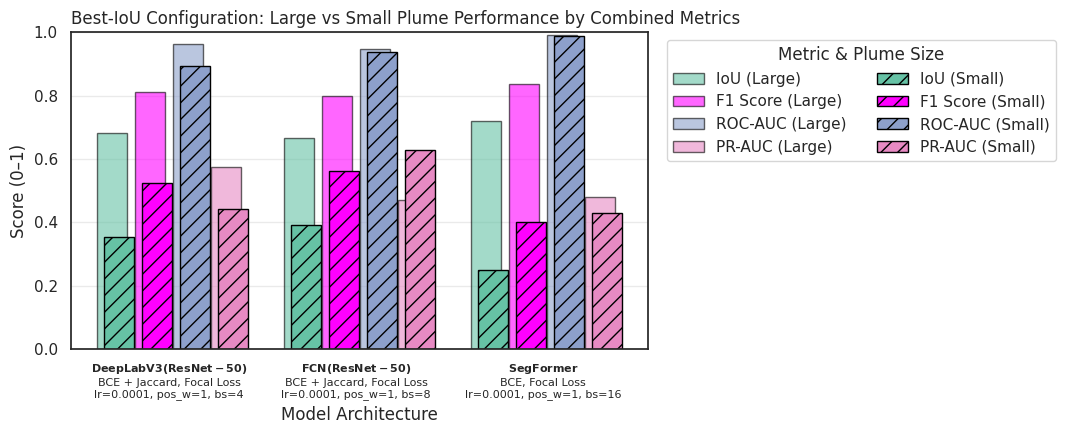

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1) Load base + thresholds
# ----------------------------
df_all = pd.read_csv("data/all_results_v2.csv")              # experiment-level (aka df_all)
df_thresholds = pd.read_csv("data/thresholded_results.csv")  # threshold-level

# Join (threshold rows + experiment metadata)
df_joined = pd.merge(
    df_thresholds,
    df_all.drop_duplicates("join_key"),
    on="join_key",
    how="left",
    suffixes=("", "_exp")
)

# ----------------------------
# 2) Build ROC-AUC & PR-AUC
# ----------------------------
def compute_roc_pr_areas(group: pd.DataFrame) -> pd.Series:
    g = group.copy()
    g = g.replace([np.inf, -np.inf], np.nan).dropna(subset=["TPR", "FPR", "precision", "recall"])

    # ---- ROC-AUC via trapezoid over FPR (x) vs TPR (y)
    roc = g[["FPR", "TPR"]].dropna().sort_values("FPR")
    if roc.empty or roc.iloc[0]["FPR"] > 0:
        roc = pd.concat([pd.DataFrame({"FPR":[0.0], "TPR":[0.0]}), roc], ignore_index=True)
    if roc.iloc[-1]["FPR"] < 1:
        roc = pd.concat([roc, pd.DataFrame({"FPR":[1.0], "TPR":[1.0]})], ignore_index=True)
    roc = roc.groupby("FPR", as_index=False)["TPR"].max().sort_values("FPR")
    roc_auc = float(np.trapz(roc["TPR"].values, roc["FPR"].values))

    # ---- PR-AUC (AP-style with precision envelope)
    pr = g[["recall", "precision"]].dropna().sort_values("recall")
    if pr.empty:
        pr_auc = np.nan
    else:
        pr["recall"] = pr["recall"].clip(0, 1)
        pr["precision"] = pr["precision"].clip(0, 1)
        prec_env = np.maximum.accumulate(pr["precision"].values[::-1])[::-1]
        if pr.iloc[0]["recall"] > 0:
            pr = pd.concat([pd.DataFrame({"recall":[0.0], "precision":[prec_env[0]]}), pr], ignore_index=True)
            prec_env = np.maximum.accumulate(pr["precision"].values[::-1])[::-1]
        r = pr["recall"].values
        pr_auc = float(np.sum((r[1:] - r[:-1]) * prec_env[1:]))

    # Baseline for AUPRC (prevalence)
    if "prevalence" in group.columns and group["prevalence"].notna().any():
        pr_baseline = float(group["prevalence"].dropna().iloc[0])
    elif {"TP","FP","TN","FN"}.issubset(group.columns):
        row = group.dropna(subset=["TP","FN","FP","TN"]).iloc[0]
        P = row["TP"] + row["FN"]
        N = row["TN"] + row["FP"]
        pr_baseline = float(P / (P + N)) if (P + N) > 0 else np.nan
    else:
        pr_baseline = np.nan

    return pd.Series({
        "metrics.roc_auc": roc_auc,
        "metrics.auprc": pr_auc,
        "metrics.auprc_baseline": pr_baseline
    })

auc_per_join = (
    df_joined
    .groupby("join_key", group_keys=False)
    .apply(compute_roc_pr_areas)
    .reset_index()
)

# Merge AUCs back into experiment-level table
df_all = df_all.merge(auc_per_join, on="join_key", how="left")

# ----------------------------
# 3) Plotting dataframe
# ----------------------------
df = df_all.copy()

# --- Architecture display names ---
architecture_mapping = {
    "fcn_resnet50": "FCN (ResNet-50)",
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "segformer": "SegFormer",
}
loss_mapping = {
    "BCEWithLogitsLoss": "BCE, Focal Loss",
    "JaccardLoss": "Jaccard (IoU), Focal Loss",
    "HybridBCEJaccardLoss": "BCE + Jaccard, Focal Loss",
}

df["model.model_architecture_display"] = df["model.model_architecture"].map(architecture_mapping)
df["model.loss_display"] = df["model.loss"].map(loss_mapping)

# --- Find best-IoU run per architecture for Easy/Hard ---
idx_easy = df.groupby("model.model_architecture")["metrics.iou_easy"].idxmax()
idx_hard = df.groupby("model.model_architecture")["metrics.iou_hard"].idxmax()
best_iou_easy_runs = df.loc[idx_easy].reset_index(drop=True)
best_iou_hard_runs = df.loc[idx_hard].reset_index(drop=True)

# Helper to append a column only if it exists
def add_if_exists(cols_list, col_name, df_cols):
    if col_name in df_cols and col_name not in cols_list:
        cols_list.append(col_name)

# --- Extract metrics to show: IoU, F1 Score (easy/hard), and overall ROC-AUC/PR-AUC ---
easy_cols = [
    "model.model_architecture_display",
    "metrics.iou_easy",
    "metrics.f1score_easy",
]
hard_cols = [
    "model.model_architecture_display",
    "metrics.iou_hard",
    "metrics.f1score_hard",
]

# Add overall AUCs (duplicated to both Large/Small since curves are overall per run)
for col in ["metrics.roc_auc", "metrics.auprc"]:
    add_if_exists(easy_cols, col, best_iou_easy_runs.columns)
    add_if_exists(hard_cols, col, best_iou_hard_runs.columns)

easy = best_iou_easy_runs[easy_cols].copy()
hard = best_iou_hard_runs[hard_cols].copy()

# --- Melt and combine ---
easy_melted = easy.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
easy_melted["Difficulty"] = "Large"
hard_melted = hard.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
hard_melted["Difficulty"] = "Small"

combined = pd.concat([easy_melted, hard_melted], ignore_index=True)

# Labels for plot (map to pretty names)
metric_mapping = {
    "metrics.iou_easy": "IoU",
    "metrics.iou_hard": "IoU",
    "metrics.f1score_easy": "F1 Score",
    "metrics.f1score_hard": "F1 Score",
    "metrics.roc_auc": "ROC-AUC",
    "metrics.auprc": "PR-AUC",
}
combined["Metric"] = combined["Metric"].map(metric_mapping).fillna(combined["Metric"])

# Keep only these (exclude precision/recall if present)
keep_metrics = {"IoU", "F1 Score", "ROC-AUC", "PR-AUC"}
combined = combined[combined["Metric"].isin(keep_metrics)].copy()

# --- Build training configuration table (for x-tick labels) ---
config_cols = [
    "model.model_architecture", "model.model_architecture_display",
    "model.loss", "model.lr", "model.pos_weight",
    "model.alpha", "dataloader.batch_size", "training.max_epochs"
]
configs = pd.concat([
    best_iou_easy_runs[config_cols].assign(Difficulty="Large"),
    best_iou_hard_runs[config_cols].assign(Difficulty="Small")
])
configs = configs.sort_values(["Difficulty", "model.model_architecture_display"]).reset_index(drop=True)

# ----------------------------
# 4) Plot (with stagger, F1 in magenta and bold label)
# ----------------------------
sns.set_theme(style="white")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 4.5))

ax.set_axisbelow(True)                     # grid behind bars
ax.yaxis.grid(True, alpha=0.4)
ax.xaxis.grid(False)                       # no vertical grid

# Nice fixed order if present
ordered = [m for m in ["IoU", "F1 Score", "ROC-AUC", "PR-AUC"] if m in combined["Metric"].unique()]
metrics_order = ordered if ordered else list(combined["Metric"].unique())
num_metrics = len(metrics_order)

# Single tuning parameter (0 = no stagger). Try 0.15, 0.25, 0.35...
STAGGER = 0.30

bar_width = 0.12                 # base width unit for per-metric offsets
BASE_SPACING = 1.3               # your original spacing
spacing = BASE_SPACING * (1 + STAGGER)   # spacing scales with STAGGER
difficulty_shift = STAGGER * bar_width   # how much to nudge "Small" to the right

seen_labels = set()

for i, metric in enumerate(metrics_order):
    subset = combined[combined["Metric"] == metric]
    x_positions = np.arange(len(subset["model.model_architecture_display"].unique()))
    width = 0.35

    for difficulty in ["Large", "Small"]:
        vals = subset[subset["Difficulty"] == difficulty]["Score"].values

        display_metric = (
            rf"$\bf{{{metric.replace(' ', r'\ ')}}}\ ({difficulty})$"
            if metric == "F1 Score"
            else f"{metric} ({difficulty})"
        )
        # Color: magenta for F1; else cycle palette
        color = "#FF00FF" if metric == "F1 Score" else palette[i % len(palette)]
        legend_label = f"{metric} ({difficulty})"

        label = legend_label if legend_label not in seen_labels else None
        if label:
            seen_labels.add(legend_label)

        # Baseline offset for metric group
        base_offset = (i - (num_metrics - 1) / 2) * bar_width * spacing
        # Apply stagger only to one difficulty ("Small") and shift to the right
        per_difficulty_offset = difficulty_shift if difficulty == "Small" else 0.0

        ax.bar(
            x_positions + base_offset + per_difficulty_offset,
            vals,
            width=width / 2.2,
            color=color,
            alpha=0.6 if difficulty == "Large" else 1.0,
            hatch="//" if difficulty == "Small" else "",
            edgecolor="black",
            label=label,
        )

# X tick labels from Large set
labels = []
for _, row in best_iou_easy_runs.iterrows():
    arch = row["model.model_architecture_display"]
    loss = row["model.loss_display"]
    lr = row["model.lr"]
    pw = row["model.pos_weight"]
    bs = int(row["dataloader.batch_size"])
    label = rf"$\bf{{{arch}}}$" + f"\n{loss}\nlr={lr}, pos_w={pw}, bs={bs}"
    labels.append(label)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=8)
fig.subplots_adjust(bottom=0.35)

ax.set_ylim(0, 1)
ax.set_ylabel("Score (0–1)")
ax.set_xlabel("Model Architecture")
ax.set_title(
    "Best-IoU Configuration: Large vs Small Plume Performance by Combined Metrics",
    x=0.58,  # nudge right (try 0.52–0.60)
    pad=6
)

# Legend
handles, labels_ = ax.get_legend_handles_labels()
ncol = 2
order = np.arange(len(labels_))
order = order.reshape(-1, ncol).T.flatten()
ax.legend(
    [handles[i] for i in order],
    [labels_[i] for i in order],
    ncol=ncol,
    title="Metric & Plume Size",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    frameon=True,
)

plt.tight_layout(rect=[0, 0, 0.78, 1])
plt.savefig("best_combined.png", bbox_inches="tight", dpi=1200)
plt.show()


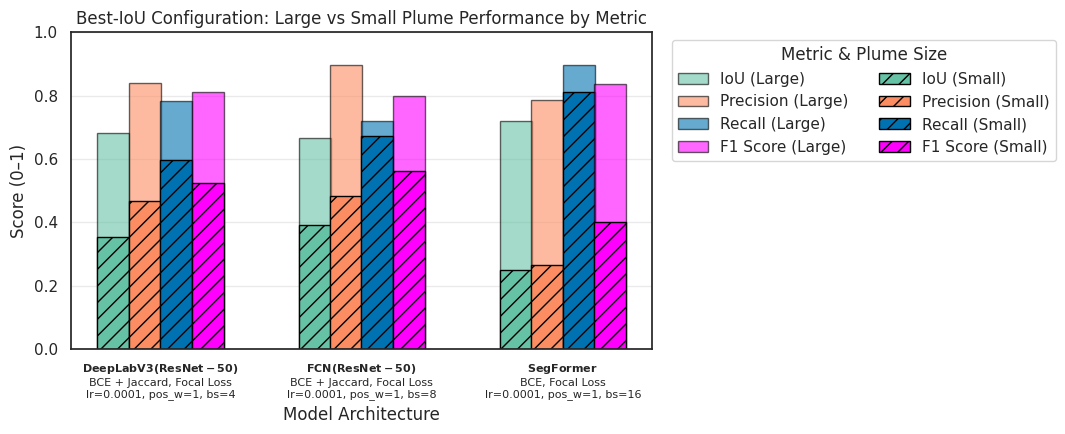

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Architecture display names ---
architecture_mapping = {
    "fcn_resnet50": "FCN (ResNet-50)",
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "segformer": "SegFormer",
}

loss_mapping = {
    "BCEWithLogitsLoss": "BCE, Focal Loss",
    "JaccardLoss": "Jaccard (IoU), Focal Loss",
    "HybridBCEJaccardLoss": "BCE + Jaccard, Focal Loss",
}


# --- Load ---
df = pd.read_csv("all_results_10-20-2024.csv")
df["model.model_architecture_display"] = df["model.model_architecture"].map(architecture_mapping)
df["model.loss_display"] = df["model.loss"].map(loss_mapping)

# --- Find best-IoU run per architecture for Easy/Hard ---
idx_easy = df.groupby("model.model_architecture")["metrics.iou_easy"].idxmax()
idx_hard = df.groupby("model.model_architecture")["metrics.iou_hard"].idxmax()
best_iou_easy_runs = df.loc[idx_easy].reset_index(drop=True)
best_iou_hard_runs = df.loc[idx_hard].reset_index(drop=True)

# --- Extract metric data ---
easy = best_iou_easy_runs[
    ["model.model_architecture_display", "metrics.iou_easy", "metrics.precision_easy", 
      "metrics.recall_easy", "metrics.f1score_easy"]
].copy()
hard = best_iou_hard_runs[
    ["model.model_architecture_display", "metrics.iou_hard", "metrics.precision_hard",
     "metrics.recall_hard", "metrics.f1score_hard"]
].copy()

easy
hard

# --- Melt and combine ---
easy_melted = easy.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
easy_melted["Difficulty"] = "Large"

hard_melted = hard.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
hard_melted["Difficulty"] = "Small"

hard_melted

combined = pd.concat([easy_melted, hard_melted], ignore_index=True)
metric_mapping = {
    "metrics.iou_easy": "IoU",
    "metrics.iou_hard": "IoU",
    "metrics.precision_easy": "Precision",
    "metrics.precision_hard": "Precision",
    "metrics.recall_easy": "Recall",
    "metrics.recall_hard": "Recall",
    "metrics.f1score_easy": "F1 Score",
    "metrics.f1score_hard": "F1 Score",
}# --- Build training configuration table ---
config_cols = [
    "model.model_architecture", "model.model_architecture_display",
    "model.loss", "model.lr", "model.pos_weight",
    "model.alpha", "dataloader.batch_size", "training.max_epochs"
]

combined["Metric"] = combined["Metric"].map(metric_mapping).fillna(combined["Metric"])

configs = pd.concat([
    best_iou_easy_runs[config_cols].assign(Difficulty="Large"),
    best_iou_hard_runs[config_cols].assign(Difficulty="Small")
])
configs = configs.sort_values(["Difficulty", "model.model_architecture_display"]).reset_index(drop=True)

# --- Plot ---
sns.set_theme(style="white")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 4.5))

ax.set_axisbelow(True)                     # grid behind bars
ax.yaxis.grid(True, alpha=0.4)
ax.xaxis.grid(False)                       # no vertical grid


num_metrics = len(combined["Metric"].unique())
bar_width = 0.12  # manually control bar width
spacing = 1.3     # tweak this to control gap between bars

for i, metric in enumerate(combined["Metric"].unique()):
    subset = combined[combined["Metric"] == metric]
    x_positions = np.arange(len(subset["model.model_architecture_display"].unique()))
    width = 0.35

    for difficulty in ["Large", "Small"]:
        vals = subset[subset["Difficulty"] == difficulty]["Score"].values

        display_metric = f"{metric} ({difficulty})"
            # rf"$\bf{{{metric.replace(' ', r'\ ')}}}\ ({difficulty})$"
            # if metric == "F1 Score"
            # else f"{metric} ({difficulty})"


        color = (
            "#FF00FF" if metric == "F1 Score"
            else "#0072B2" if metric == "Recall"   # <-- different color for Recall
            else palette[i]
        )

        offset = (i - (num_metrics - 1) / 2) * bar_width * spacing
        ax.bar(
            x_positions + offset,
            vals,
            width=width / 2.2,
            color=color,
            alpha=0.6 if difficulty == "Large" else 1.0,
            hatch="//" if difficulty == "Small" else "",
            edgecolor="black",
            label=display_metric,
        )
labels = []

for _, row in best_iou_easy_runs.iterrows():
    arch = row["model.model_architecture_display"]
    loss = row["model.loss_display"]
    lr = row["model.lr"]
    pw = row["model.pos_weight"]
    bs = int(row["dataloader.batch_size"])
    label = rf"$\bf{{{arch}}}$" + f"\n{loss}\nlr={lr}, pos_w={pw}, bs={bs}"
    labels.append(label)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=8)
fig.subplots_adjust(bottom=0.35)

ax.set_ylim(0, 1)
ax.set_ylabel("Score (0–1)")
ax.set_xlabel("Model Architecture")
ax.set_title("Best-IoU Configuration: Large vs Small Plume Performance by Metric")

# --- Legend ---
handles, labels = ax.get_legend_handles_labels()
ncol = 2
order = np.arange(len(labels))
order = order.reshape(-1, ncol).T.flatten()

ax.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    ncol=ncol,
    title="Metric & Plume Size",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
frameon=True,
)

plt.tight_layout(rect=[0, 0, 0.78, 1])
plt.savefig(f"precision_recall.png", dpi=1200, bbox_inches="tight", pad_inches=0.02)
plt.show()
